### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage import io
from skimage.color import rgb2gray

### IMPORTING / VIEWING / PREPROCESSING DATASET 

> `DATA AUGMENTATION`

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
test_dataset = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


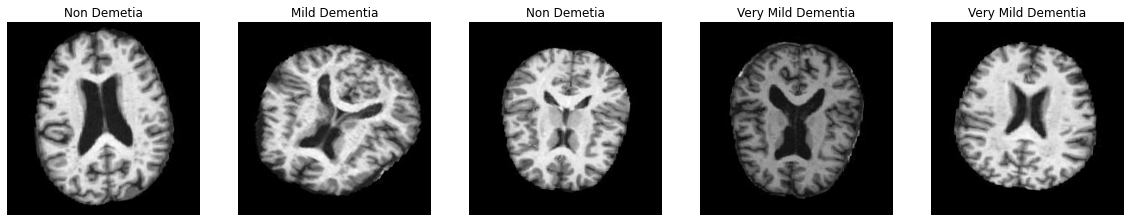

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [7]:
base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

2023-01-07 09:38:36.643111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 09:38:36.644129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 09:38:36.833197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 09:38:36.834074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 09:38:36.834833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [9]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [10]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [11]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.AUC(name = 'auc'),
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [14]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 30,
                        callbacks = callback_list,
                        verbose = 1)

2023-01-07 09:39:15.271700: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-07 09:39:21.808471: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


33/33 [==============================] - 141s 3s/step - loss: 1.3958 - auc: 0.7741 - accuracy: 0.7595 - precision: 0.5213 - recall: 0.4651 - f1_score: 0.4906 - val_loss: 1.5103 - val_auc: 0.7396 - val_accuracy: 0.7568 - val_precision: 0.5159 - val_recall: 0.4448 - val_f1_score: 0.4777

Epoch 00001: val_auc improved from -inf to 0.73961, saving model to ./best_weights.hdf5
Epoch 2/30
33/33 [==============================] - 70s 2s/step - loss: 1.1886 - auc: 0.8079 - accuracy: 0.7732 - precision: 0.5528 - recall: 0.4863 - f1_score: 0.5017 - val_loss: 1.2109 - val_auc: 0.7416 - val_accuracy: 0.7796 - val_precision: 0.5947 - val_recall: 0.3715 - val_f1_score: 0.4573

Epoch 00002: val_auc improved from 0.73961 to 0.74158, saving model to ./best_weights.hdf5
Epoch 3/30
33/33 [==============================] - 65s 2s/step - loss: 1.0328 - auc: 0.8316 - accuracy: 0.7861 - precision: 0.5839 - recall: 0.5029 - f1_score: 0.5541 - val_loss: 1.1779 - val_auc: 0.7420 - val_accuracy: 0.7617 - val_pre

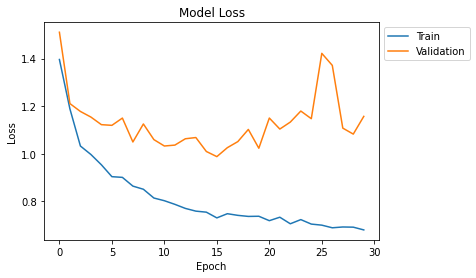

In [15]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

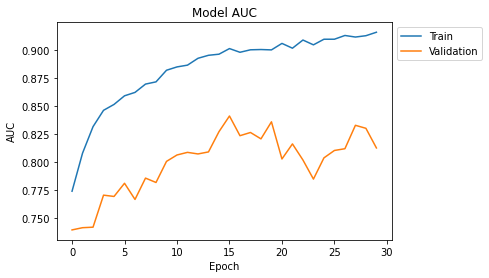

In [16]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [17]:
model.evaluate(test_dataset)


40/40 [==============================] - 24s 455ms/step - loss: 0.8486 - auc: 0.8751 - accuracy: 0.8174 - precision: 0.6651 - recall: 0.5434 - f1_score: 0.5963


[0.8485534191131592,
 0.8750938177108765,
 0.8174355030059814,
 0.6650717854499817,
 0.5433932542800903,
 0.5963059067726135]

In [18]:
def predict_prob(number):
    return [number[0],1-number[0]]

98.42 % chances are there that the image is [2]


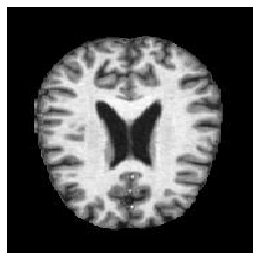

In [19]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is', classes)

77.05 % chances are there that the image is [0]


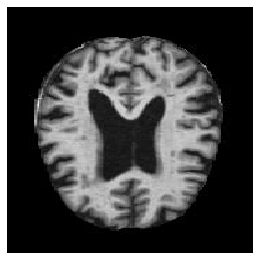

In [20]:
# Test Case 2: Mild-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (27).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is', classes)

97.95 % chances are there that the image is [1]


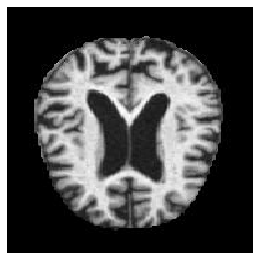

In [21]:
# Test Case 3: Moderate-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is', classes)

67.88 % chances are there that the image is [0]


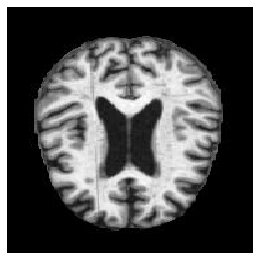

In [22]:
# Test Case4 : Moderate-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented/26 (52).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is', classes)

In [26]:
test_datagen2  = ImageDataGenerator(rescale = 1./255)
# Test Data 

test_dataset2  = test_datagen.flow_from_directory(directory = '/kaggle/input/alzheimer-mri-dataset/Dataset',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 6400 images belonging to 4 classes.


In [27]:
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.AUC(name = 'auc'),
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)


In [28]:
# Evaluating Loss and AUC

model.evaluate(test_dataset2)

50/50 [==============================] - 58s 1s/step - loss: 0.7258 - auc: 0.9106 - accuracy: 0.8548 - precision: 0.7371 - recall: 0.6516 - f1_score: 0.6915


[0.7258197665214539,
 0.9106451272964478,
 0.8548046946525574,
 0.7371398210525513,
 0.651562511920929,
 0.691501796245575]